In [1]:
import functions_tunning as ft
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from skopt.space import Integer, Real, Categorical
import os
import re
import itertools

In [2]:
dataset_targets = {
    "depression\\depression_transformed.csv": "History of Mental Illness", # 1 - tak, 0 - nie
    "diabetes\\diabetes_transformed.csv": "diabetes", # 0 - brak cukrzycy, 1 - obecna cukrzyca
    "loan\\loan_transformed.csv": "charged_off", # 1 - brak spłaty, 0 - spłacona
    "weather\\weather_transformed.csv": "RainTomorrow" # 1 -będzie padać jutro, 0 - nie będzie padać jutro
}

datasets = ['Depression', 'Diabetes', 'Loan', 'Weather']

## Podział zbioru danych i wybór modeli

In [3]:
X_train0, X_test0, y_train0, y_test0 = ft.load_and_split(list(dataset_targets.keys())[0], dataset_targets[list(dataset_targets.keys())[0]])
X_train1, X_test1, y_train1, y_test1 = ft.load_and_split(list(dataset_targets.keys())[1], dataset_targets[list(dataset_targets.keys())[1]])
X_train2, X_test2, y_train2, y_test2 = ft.load_and_split(list(dataset_targets.keys())[2], dataset_targets[list(dataset_targets.keys())[2]])
X_train3, X_test3, y_train3, y_test3 = ft.load_and_split(list(dataset_targets.keys())[3], dataset_targets[list(dataset_targets.keys())[3]])

In [4]:
model1 = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")
model2 = RandomForestClassifier(random_state=42)
model3 = LogisticRegression(random_state=42)
models = [model1, model2, model3]
models_names = [type(model).__name__ for model in models]

## Siatki modeli

In [5]:
logistic_random_param_grid = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': loguniform(1e-3, 1e3),
        'max_iter': randint(1000, 4000)
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'l1_ratio': uniform(0.05, 0.9),
        'C': loguniform(1e-3, 1e3),
        'max_iter': randint(1000, 4000)
    }
]

logistic_bayes_param_grid = [
    ({
        'solver': Categorical(['lbfgs']),
        'penalty': Categorical(['l2']),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25),  # liczba prób dla tej przestrzeni
    ({
        'solver': Categorical(['saga']),
        'penalty': Categorical(['l1', 'l2']),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25),
    ({
        'solver': Categorical(['saga']),
        'penalty': Categorical(['elasticnet']),
        'l1_ratio': Real(0.05, 0.9),
        'C': Real(1e-3, 1e3, prior='log-uniform'),
        'max_iter': Integer(1000, 4000)
    }, 25)
]

xgb_random_param_grid = {
    "n_estimators": randint(300, 1200),
    "max_depth": randint(3, 8),
    "learning_rate": loguniform(0.01, 0.1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 8),
    "gamma": uniform(0.0, 3.0),
    "reg_lambda": uniform(0.0, 10.0),
    "reg_alpha": uniform(0.0, 5.0),
    "scale_pos_weight": uniform(1.0, 5.0),
}

xgb_bayes_param_grid =  {
    "n_estimators": Integer(300, 1200),
    "max_depth": Integer(3, 8),
    "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "min_child_weight": Integer(1, 8),
    "gamma": Real(0.0, 3.0),
    "reg_lambda": Real(0.0, 10.0),
    "reg_alpha": Real(0.0, 5.0),
    "scale_pos_weight": Real(1.0, 5.0)
}

forest_bayes_param_grid = {
    "n_estimators": Integer(10, 200),            # liczba drzew — większa = stabilniejszy model, ale wolniejszy
    "max_depth": Integer(2, 20),                   # głębokość drzewa — zbyt duża = przeuczenie
    "min_samples_split": Integer(2, 8),           # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": Integer(1, 5),             # minimalna liczba próbek w liściu
    "max_features": Categorical(["sqrt", "log2", None]),  # ile cech losować — klasyczne podejścia
    "bootstrap": Categorical([True, False]),       # losowanie z powtórzeniem
    "criterion": Categorical(["gini", "entropy", "log_loss"]),  # funkcja oceny podziału
    "class_weight": Categorical([None, "balanced"]) # balans klas
}

forest_random_param_grid = {
    "n_estimators": randint(10, 200),            # liczba drzew — większa = stabilniejszy model, ale wolniejszy
    "max_depth": randint(2, 20),                   # głębokość drzewa — zbyt duża = przeuczenie
    "min_samples_split": randint(2, 8),           # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": randint(1, 5),             # minimalna liczba próbek w liściu
    "max_features": ["sqrt", "log2", None],  # ile cech losować — klasyczne podejścia
    "bootstrap": [True, False],       # losowanie z powtórzeniem
    "criterion": ["gini", "entropy", "log_loss"],  # funkcja oceny podziału
    "class_weight": [None, "balanced"] # balans klas
}

## Szukanie najlepszych hiperparametrów dla par model - zbiór danych

Wyniki tej części zapisane do plików w folderze 'results_tunning'

In [6]:
#results_rs1, results_bs1, scores_rs1, full_results_df1 = ft.tune_for_each_data(model1, xgb_random_param_grid, xgb_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

In [7]:
#results_rs2, results_bs2, scores_rs2, full_results_df2 = ft.tune_for_each_data(model2, forest_random_param_grid, forest_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

In [8]:
#results_rs3, results_bs3, scores_rs3, full_results_df3 = ft.tune_for_each_data(model3, logistic_random_param_grid, logistic_bayes_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

### Wykresy mean_test_score w zależności od iteracji

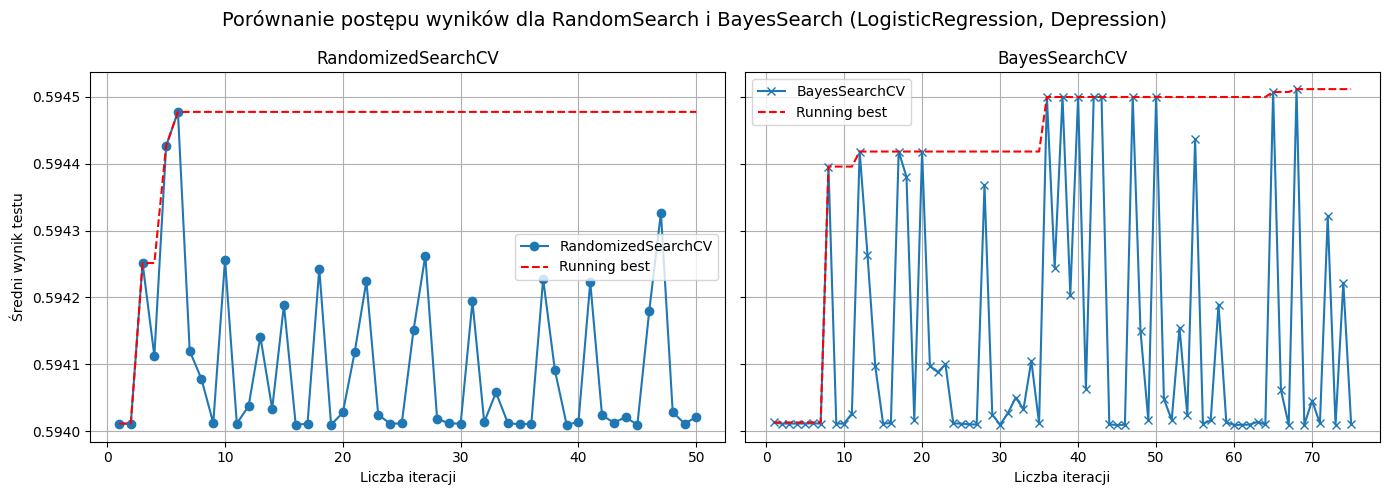

Najlepsze hiperparametry random: {'C': np.float64(0.001102548826429165), 'l1_ratio': np.float64(0.07075618253727418), 'max_iter': 1474, 'penalty': 'elasticnet', 'solver': 'saga'}
Najlepszy wynik random: 0.5944772649432619
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.001, 'l1_ratio': 0.8332849911633243, 'max_iter': 1234, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.5945113043251634


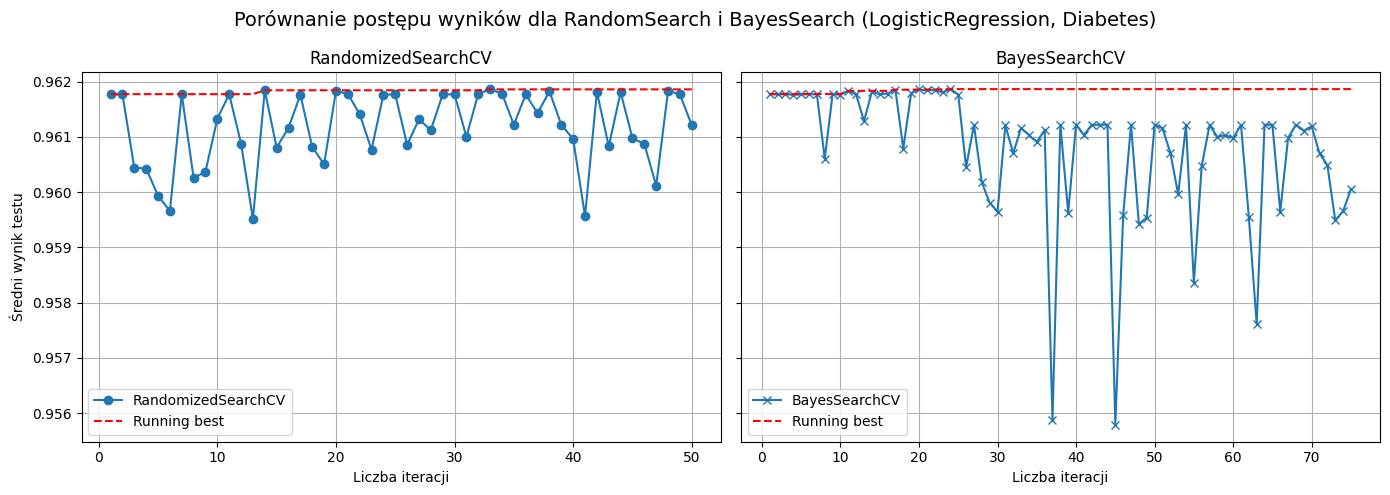

Najlepsze hiperparametry random: {'C': np.float64(0.016229876459045892), 'max_iter': 1863, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy wynik random: 0.9618606845182524
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.016498019365266195, 'max_iter': 3999, 'penalty': 'l2', 'solver': 'lbfgs'})
Najlepszy wynik bayes: 0.9618650565029488


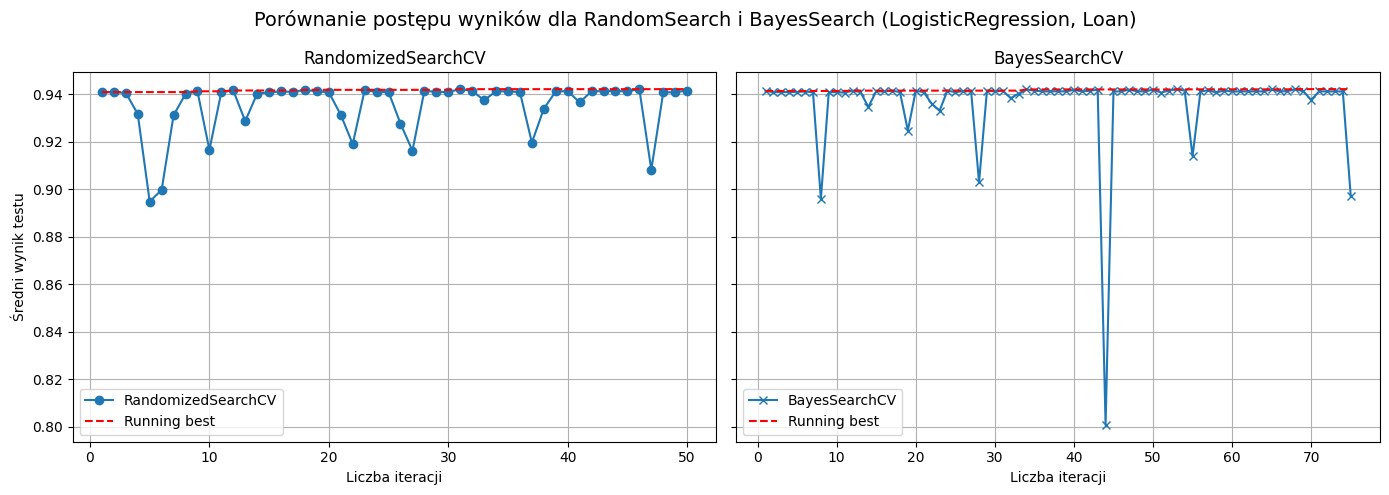

Najlepsze hiperparametry random: {'C': np.float64(0.030287008332244233), 'l1_ratio': np.float64(0.6766738455558096), 'max_iter': 2636, 'penalty': 'l1', 'solver': 'saga'}
Najlepszy wynik random: 0.9420799663721456
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.04551731629996138, 'l1_ratio': 0.9, 'max_iter': 4000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.9420900826819302


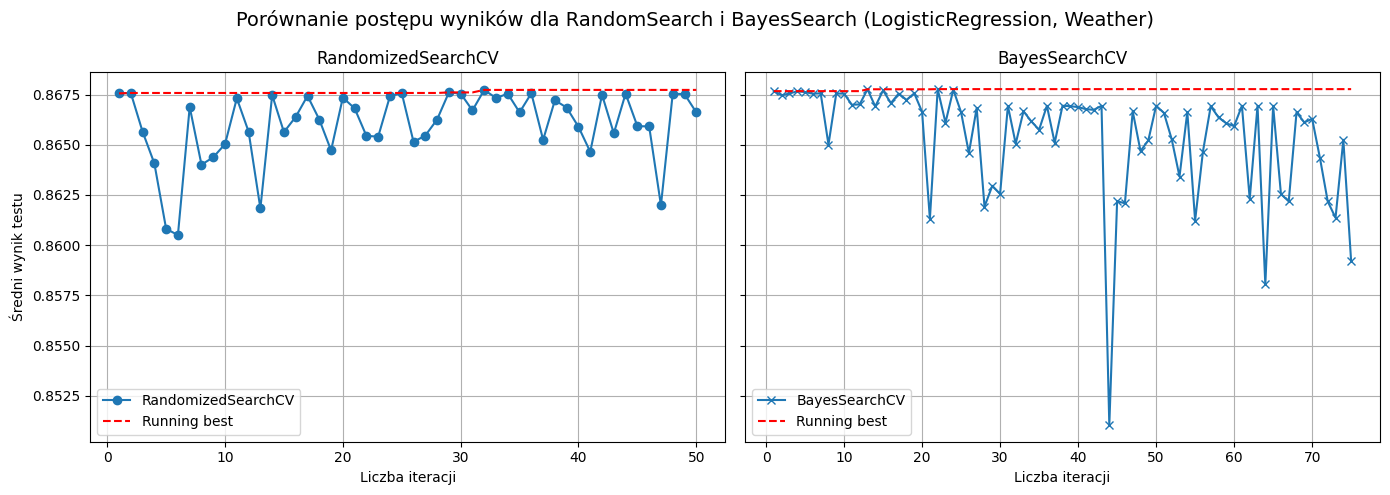

Najlepsze hiperparametry random: {'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy wynik random: 0.867728359649914
Najlepsze hiperparametry bayes: OrderedDict({'C': 982.7569147820517, 'max_iter': 3906, 'penalty': 'l2', 'solver': 'lbfgs'})
Najlepszy wynik bayes: 0.8677676767339761


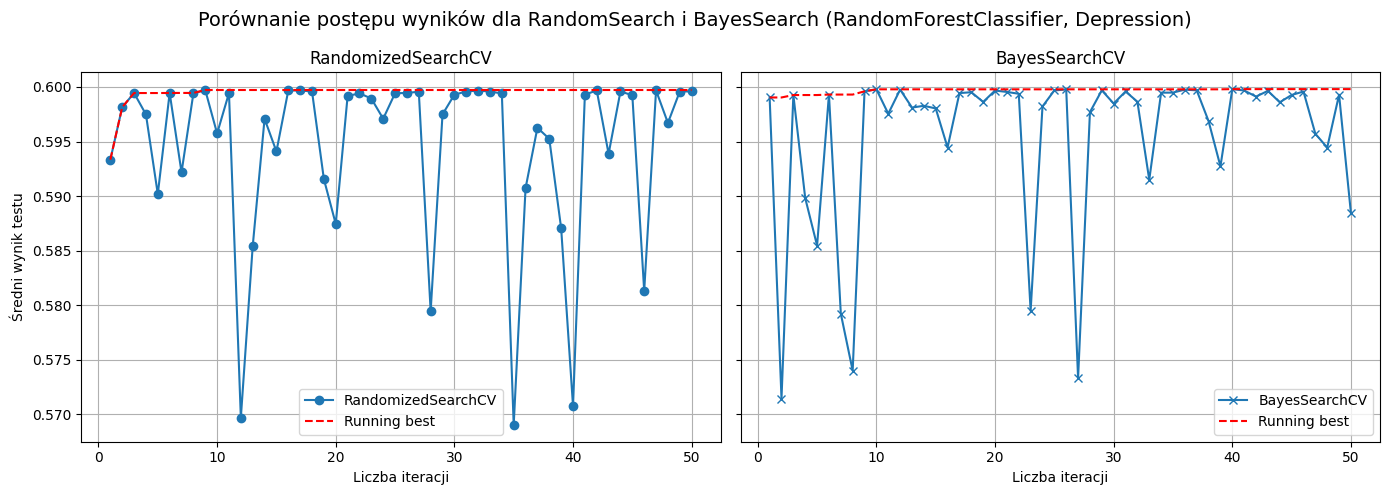

Najlepsze hiperparametry random: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
Najlepszy wynik random: 0.5997224955222544
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 11})
Najlepszy wynik bayes: 0.5998035520824005


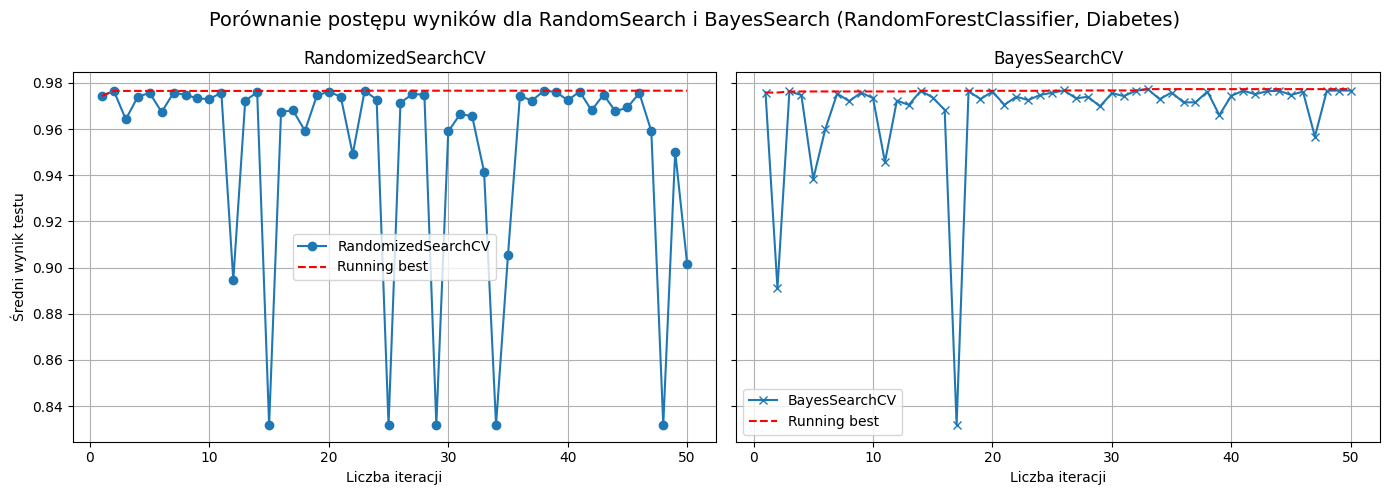

Najlepsze hiperparametry random: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 199}
Najlepszy wynik random: 0.9766276982616394
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200})
Najlepszy wynik bayes: 0.9773099640896546


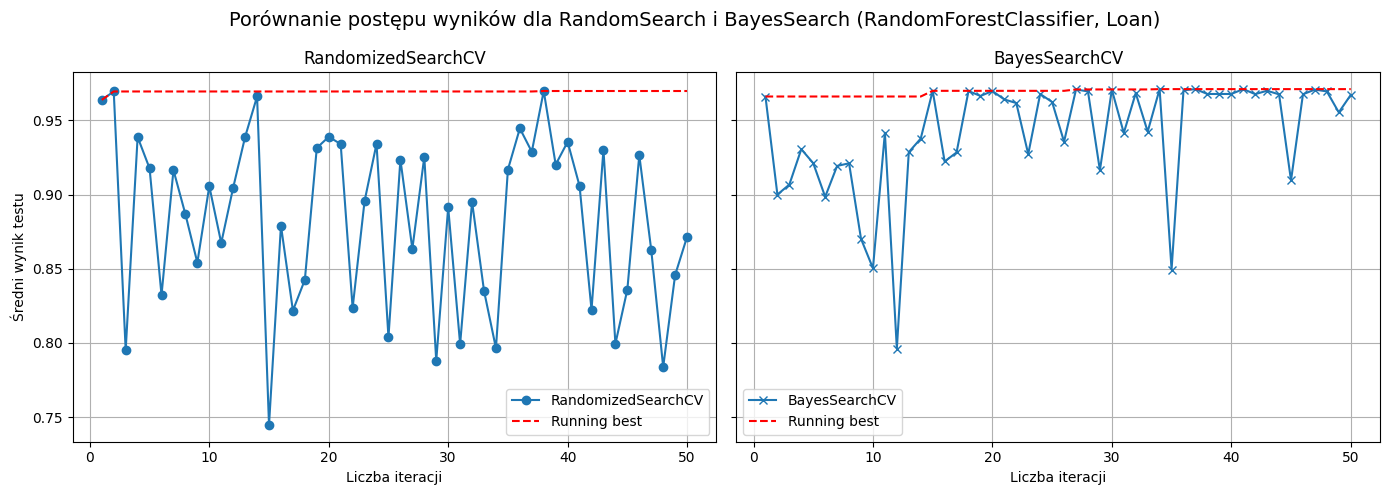

Najlepsze hiperparametry random: {'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}
Najlepszy wynik random: 0.969792266158096
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200})
Najlepszy wynik bayes: 0.9710666343279826


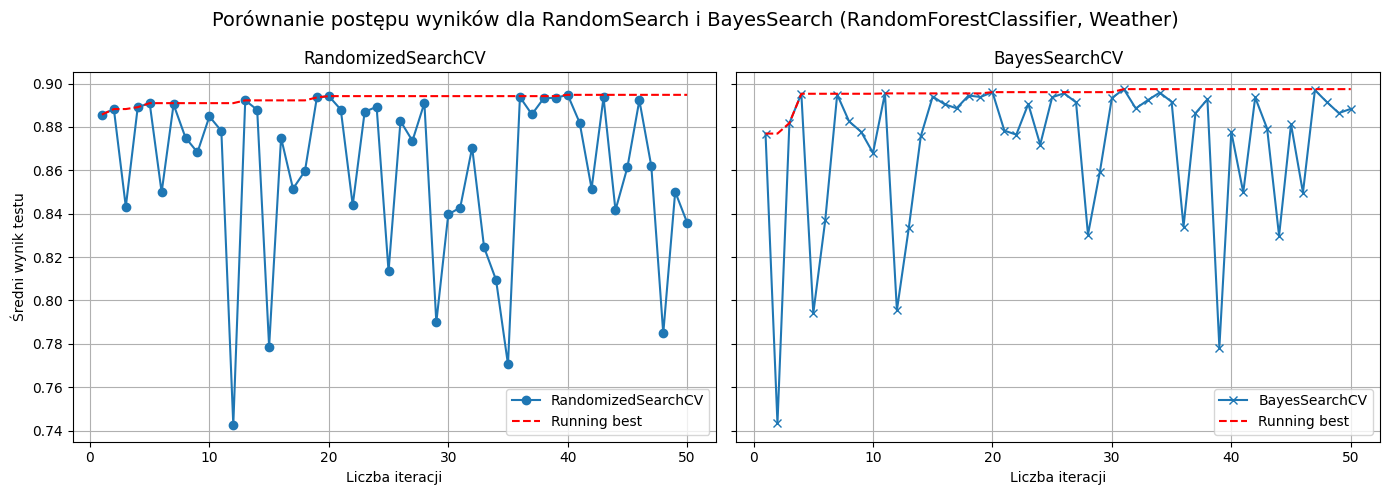

Najlepsze hiperparametry random: {'bootstrap': False, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 63}
Najlepszy wynik random: 0.8947987012335966
Najlepsze hiperparametry bayes: OrderedDict({'bootstrap': False, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200})
Najlepszy wynik bayes: 0.8974349577644395


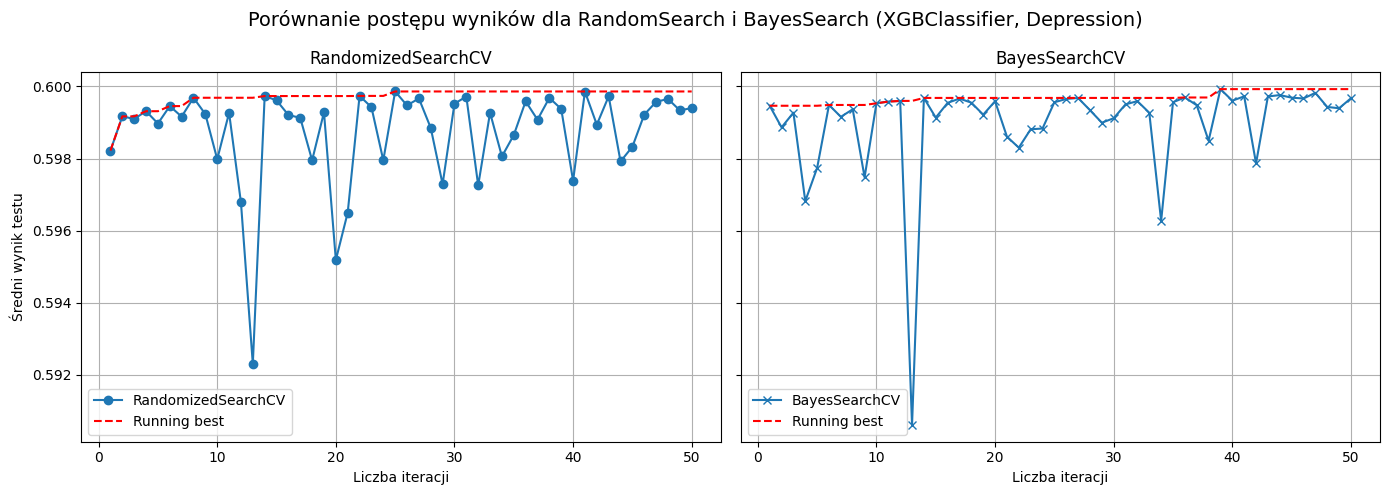

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.052594450770640004), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1182, 'reg_alpha': np.float64(3.1816630909294767), 'reg_lambda': np.float64(2.5046181860558416), 'scale_pos_weight': np.float64(3.9493542378027193), 'subsample': np.float64(0.9915571433100037)}
Najlepszy wynik random: 0.5998603263325376
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.7111210550630757, 'gamma': 0.9499669564931629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 805, 'reg_alpha': 4.233746119318801, 'reg_lambda': 7.879285345319937, 'scale_pos_weight': 3.916532548531401, 'subsample': 1.0})
Najlepszy wynik bayes: 0.5999253156503642


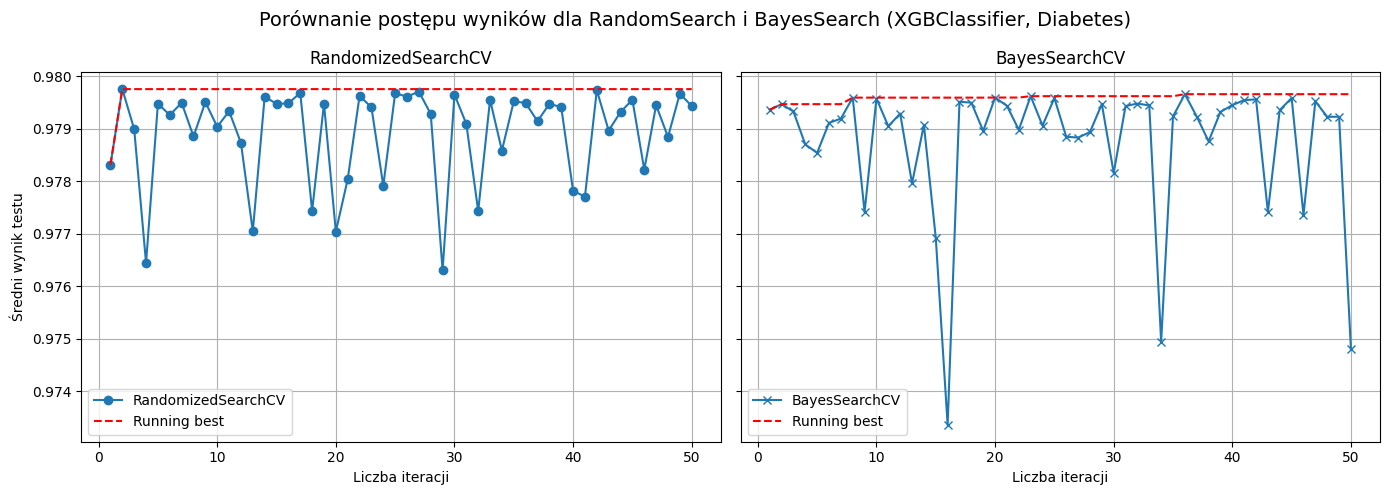

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.6571467271687763), 'gamma': np.float64(1.9526654188465586), 'learning_rate': np.float64(0.011387059213756823), 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 1105, 'reg_alpha': np.float64(0.0038938292050716417), 'reg_lambda': np.float64(9.922115592912174), 'scale_pos_weight': np.float64(4.087407548138582), 'subsample': np.float64(0.8446612641953124)}
Najlepszy wynik random: 0.9797579427827654
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.916517218733089, 'gamma': 2.503898278758046, 'learning_rate': 0.04673720149002265, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 471, 'reg_alpha': 1.4313802415154302, 'reg_lambda': 7.441564665354836, 'scale_pos_weight': 4.952524398170244, 'subsample': 1.0})
Najlepszy wynik bayes: 0.9796616105308384


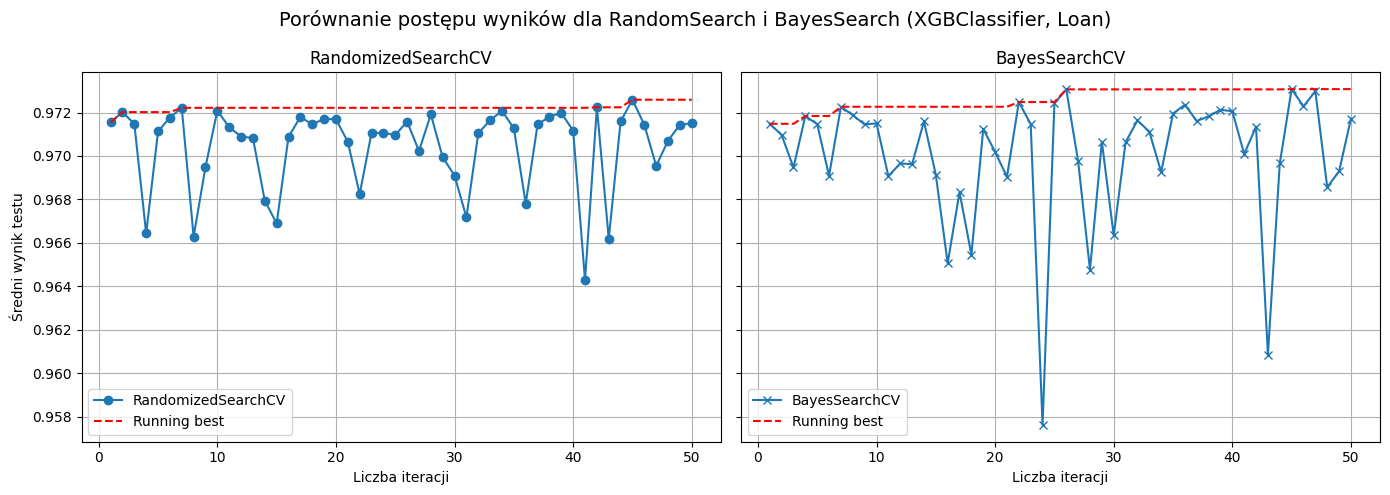

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.8137309894122253), 'gamma': np.float64(1.4896835720492332), 'learning_rate': np.float64(0.02452551220584918), 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 318, 'reg_alpha': np.float64(1.9460083936708155), 'reg_lambda': np.float64(0.1083765148029836), 'scale_pos_weight': np.float64(5.5269098820963185), 'subsample': np.float64(0.6365146707144534)}
Najlepszy wynik random: 0.9725896931748128
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 1.0, 'gamma': 3.0, 'learning_rate': 0.02786530452007804, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 750, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 5.0, 'subsample': 0.66990478096725})
Najlepszy wynik bayes: 0.9730767409993876


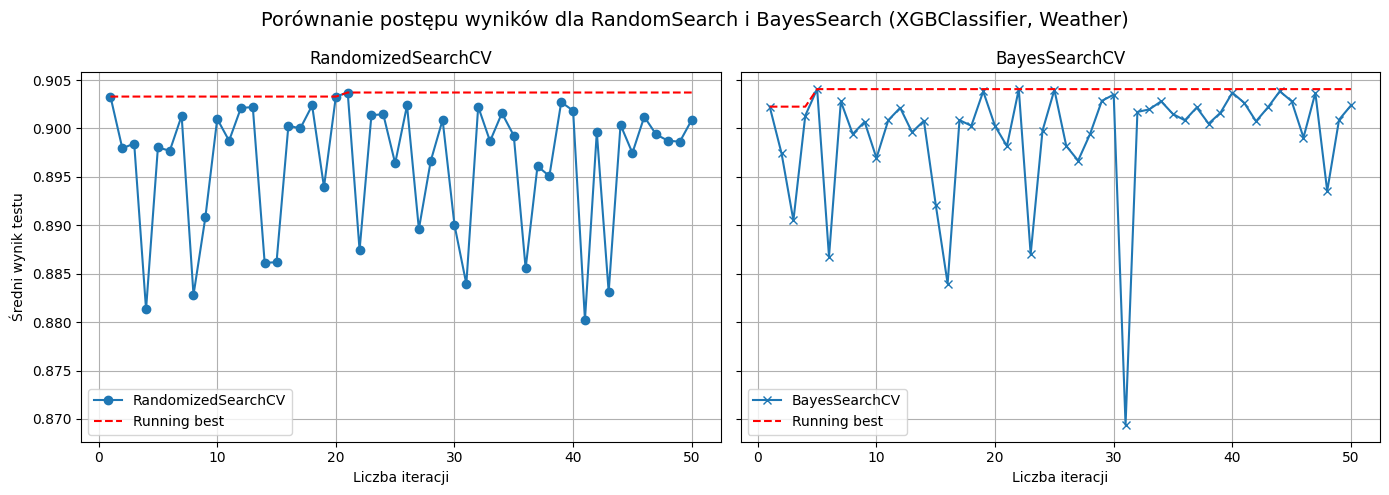

Najlepsze hiperparametry random: {'colsample_bytree': np.float64(0.6836286482950855), 'gamma': np.float64(1.6243439214826974), 'learning_rate': np.float64(0.04963458549101888), 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 923, 'reg_alpha': np.float64(2.7760040579973118), 'reg_lambda': np.float64(5.296505783560065), 'scale_pos_weight': np.float64(2.2092614545022586), 'subsample': np.float64(0.6372411071223597)}
Najlepszy wynik random: 0.903715996878516
Najlepsze hiperparametry bayes: OrderedDict({'colsample_bytree': 0.9198213766428692, 'gamma': 1.31408755932277, 'learning_rate': 0.033621744005164336, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 945, 'reg_alpha': 2.1208903623034105, 'reg_lambda': 6.5028410174776266, 'scale_pos_weight': 2.412335382111886, 'subsample': 0.8637704914796385})
Najlepszy wynik bayes: 0.9040663243932344


In [9]:
pattern = re.compile(r'random_search_results_(\w+)_dataset_(\d+)\.csv')

for filename in os.listdir('results_tunning'):
    results_rs = pd.read_csv(os.path.join('results_tunning', filename))
    if match := pattern.match(filename):
        model_name = match.group(1)
        dataset_num = match.group(2)
        results_bs = pd.read_csv(os.path.join('results_tunning', f'bayes_search_results_{model_name}_dataset_{dataset_num}.csv'))   
        ft.plots_iterations(results_rs, results_bs, model_name, datasets[int(dataset_num)])

Z otrzymanych wykresów możemy odczytać po ilu iteracjach każda z metod znajduje już parametry otrzymujące najlepszy wynik.

### Najlepsze dopasowania

In [6]:
best_params = {}
for model in models:
    for dataset_num in range(len(datasets)):
        model_name, params, score = ft.get_best_result('random',type(model).__name__, dataset_num)
        best_params[(model_name, dataset_num)] = params, score

Dla modelu XGBClassifier i ramki danych 0:
Najlepsze hiperparametry: {'colsample_bytree': np.float64(0.7465875138331439), 'gamma': np.float64(2.232511569169687), 'learning_rate': np.float64(0.052594450770640004), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1182, 'reg_alpha': np.float64(3.1816630909294767), 'reg_lambda': np.float64(2.5046181860558416), 'scale_pos_weight': np.float64(3.9493542378027193), 'subsample': np.float64(0.9915571433100037)}
Najlepszy wynik: 0.5998603263325376
Dla modelu XGBClassifier i ramki danych 1:
Najlepsze hiperparametry: {'colsample_bytree': np.float64(0.6571467271687763), 'gamma': np.float64(1.9526654188465586), 'learning_rate': np.float64(0.011387059213756823), 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 1105, 'reg_alpha': np.float64(0.0038938292050716417), 'reg_lambda': np.float64(9.922115592912174), 'scale_pos_weight': np.float64(4.087407548138582), 'subsample': np.float64(0.8446612641953124)}
Najlepszy wynik: 0.9797579427827654
Dl

In [7]:
best_params_bayes = {}
for model in models:
    for dataset_num in range(len(datasets)):
        model_name, params, score = ft.get_best_result('bayes',type(model).__name__, dataset_num)
        best_params_bayes[(model_name, dataset_num)] = params, score

Dla modelu XGBClassifier i ramki danych 0:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 0.7111210550630757, 'gamma': 0.9499669564931629, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 805, 'reg_alpha': 4.233746119318801, 'reg_lambda': 7.879285345319937, 'scale_pos_weight': 3.916532548531401, 'subsample': 1.0})
Najlepszy wynik: 0.5999253156503642
Dla modelu XGBClassifier i ramki danych 1:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 0.916517218733089, 'gamma': 2.503898278758046, 'learning_rate': 0.04673720149002265, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 471, 'reg_alpha': 1.4313802415154302, 'reg_lambda': 7.441564665354836, 'scale_pos_weight': 4.952524398170244, 'subsample': 1.0})
Najlepszy wynik: 0.9796616105308384
Dla modelu XGBClassifier i ramki danych 2:
Najlepsze hiperparametry: OrderedDict({'colsample_bytree': 1.0, 'gamma': 3.0, 'learning_rate': 0.02786530452007804, 'max_depth': 6, 'min_child_weight': 1, 'n_

## Wyznaczenie uniwersalnych hiperparametrów dla każego modelu

In [8]:
default_params = {}
for model in models:
    model_name = type(model).__name__
    params, score, merged_df = ft.search_default(model_name)
    default_params[model_name] = params, score

Dla modelu XGBClassifier:
Najlepsze hiperparametry domyślne: {'colsample_bytree': np.float64(0.6192235696788134), 'gamma': np.float64(2.847437194774158), 'learning_rate': np.float64(0.07703363425882112), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1061, 'reg_alpha': np.float64(4.667181540397415), 'reg_lambda': np.float64(5.010398839152592), 'scale_pos_weight': np.float64(3.6968872420003125), 'subsample': np.float64(0.8735855077592565)}
Najlepszy (średni) wynik domyślny: 0.8633744819108536
Dla modelu RandomForestClassifier:
Najlepsze hiperparametry domyślne: {'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 129}
Najlepszy (średni) wynik domyślny: 0.8586951360842019
Dla modelu LogisticRegression:
Najlepsze hiperparametry domyślne: {'C': np.float64(0.3674904945305324), 'max_iter': 3939, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepszy (średni) wynik domyślny: 0.84

Dla parametrów wyznaczonych za pomoca random search:

In [59]:
# for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
#     b = best_params[(models_names[j], i)]
#     d = default_params[models_names[j]]
#     print("Dla modelu", models_names[j], "i zbioru danych", datasets[i], ":")
#     print("  Najlepsze parametry:", b[0])
#     print("  Domyślne parametry:", d[0])
#     print(f"Różnica roc_auc: {b[1] - d[1]:.2f}")

Dla paramerów wyznaczonych za pomocą Bayes Search:

In [60]:
# for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
#     b = best_params_bayes[(models_names[j], i)]
#     d = default_params[models_names[j]]
#     print("Dla modelu", models_names[j], "i zbioru danych", datasets[i], ":")
#     print("  Najlepsze parametry:", b[0])
#     print("  Domyślne parametry:", d[0])
#     print(f"Różnica roc_auc: {b[1] - d[1]:.2f}")

Wyniki takie same jak powyżej ale zapisane do zmiennych

In [61]:
# diff_model = {}
# for model_name in models_names:
#     diff_scores = {}
#     for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
#         best_score = best_params[(models_names[j], i)][1]
#         default_score = default_params[models_names[j]][1]
#         diff_scores[(models_names[j], datasets[i])] = best_score - default_score
#     diffs = [diff_scores[(model_name, dataset)] for dataset in datasets] 
#     diff_model[model_name] = diffs

In [62]:
# diff_model_bayes = {}
# for model_name in models_names:
#     diff_scores = {}
#     for i, j in itertools.product(range(len(datasets)), range(len(models_names))):
#         best_score = best_params_bayes[(models_names[j], i)][1]
#         default_score = default_params[models_names[j]][1]
#         diff_scores[(models_names[j], datasets[i])] = best_score - default_score
#     diffs = [diff_scores[(model_name, dataset)] for dataset in datasets] 
#     diff_model_bayes[model_name] = diffs

In [9]:
def get_results(mode, model_name, df_number):
    if mode == 'bayes':
        df = pd.read_csv(os.path.join('results_tunning', f'bayes_search_results_{model_name}_dataset_{df_number}.csv'))
    else:
        df = pd.read_csv(os.path.join('results_tunning', f'random_search_results_{model_name}_dataset_{df_number}.csv'))

    return df.dropna(subset=['mean_test_score']).copy()


Ramka danych zawiarająca różnice score dla każdego modelu i jego domyślnego parametru.

In [10]:
data_full = pd.DataFrame(columns=['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score'])
for model in models:
    def_score = default_params[type(model).__name__][1]
    for dataset_num in range(len(datasets)):
        df = get_results('random',type(model).__name__, dataset_num)
        df['diff_score'] = df['mean_test_score'] - def_score
        df['Model'] = type(model).__name__
        df['Dataset'] = datasets[dataset_num]
        data_full = pd.concat([data_full, df[['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score']]], ignore_index=True)

C:\Users\alapr\AppData\Local\Temp\ipykernel_37048\442646589.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, df[['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score']]], ignore_index=True)


In [11]:
data_full_bayes = pd.DataFrame(columns=['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score'])
for model in models:
    def_score = default_params[type(model).__name__][1]
    for dataset_num in range(len(datasets)):
        df = get_results('bayes',type(model).__name__, dataset_num)
        df['diff_score'] = df['mean_test_score'] - def_score
        df['Model'] = type(model).__name__
        df['Dataset'] = datasets[dataset_num]
        data_full_bayes = pd.concat([data_full_bayes, df[['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score']]], ignore_index=True)

C:\Users\alapr\AppData\Local\Temp\ipykernel_37048\331701117.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full_bayes = pd.concat([data_full_bayes, df[['Model', 'Dataset', 'params', 'mean_test_score', 'diff_score']]], ignore_index=True)


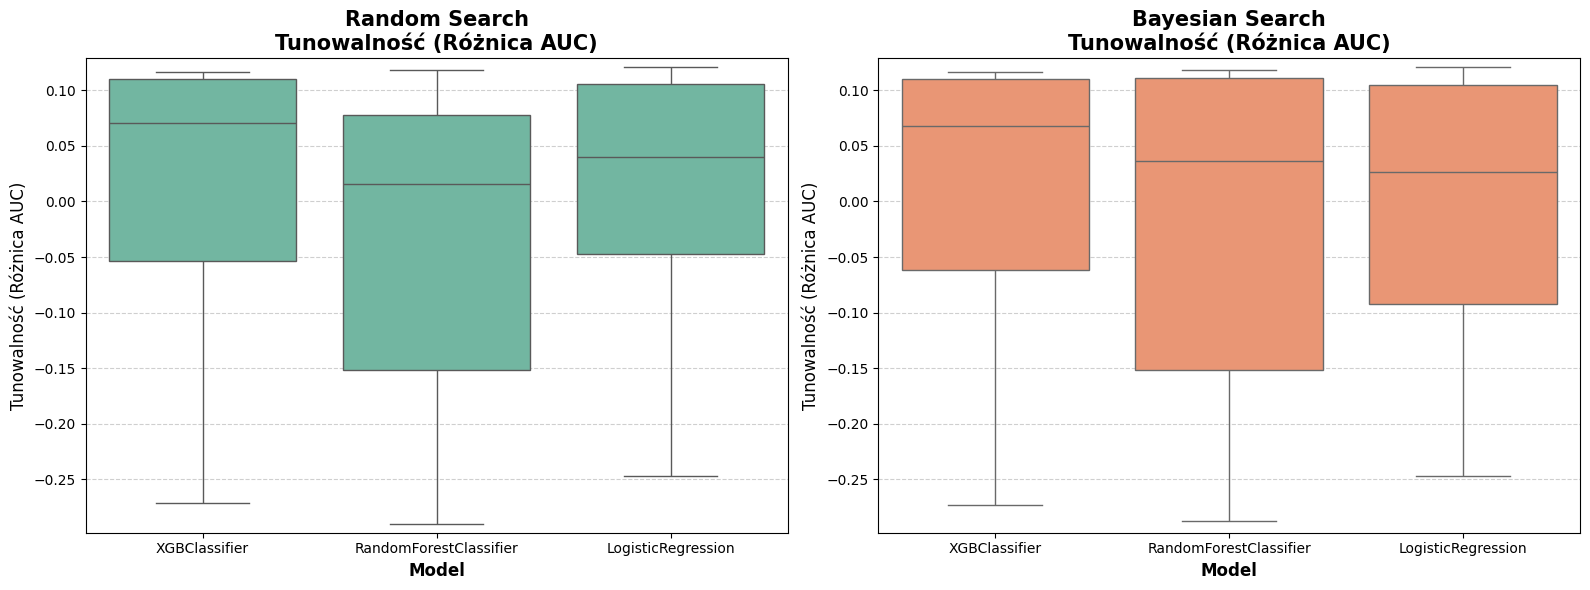

In [12]:
min_val = min(data_full['diff_score'].min(), data_full_bayes['diff_score'].min())
max_val = max(data_full['diff_score'].max(), data_full_bayes['diff_score'].max())

margin = 0.02 * (max_val - min_val)
ymin, ymax = min_val - margin, max_val + margin


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='Model', y='diff_score', data=data_full, ax=ax[0], color = sns.color_palette("Set2")[0])
ax[0].set_title("Random Search\nTunowalność (Różnica AUC)", fontsize=15, fontweight='bold')
ax[0].set_xlabel("Model", fontsize=12, fontweight='bold')
ax[0].set_ylabel("Tunowalność (Różnica AUC)", fontsize=12)
ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[0].set_ylim(ymin, ymax)

sns.boxplot(x='Model', y='diff_score', data=data_full_bayes, ax=ax[1], color = sns.color_palette("Set2")[1])
ax[1].set_title("Bayesian Search\nTunowalność (Różnica AUC)", fontsize=15, fontweight='bold')
ax[1].set_xlabel("Model", fontsize=12, fontweight='bold')
ax[1].set_ylabel("Tunowalność (Różnica AUC)", fontsize=12)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


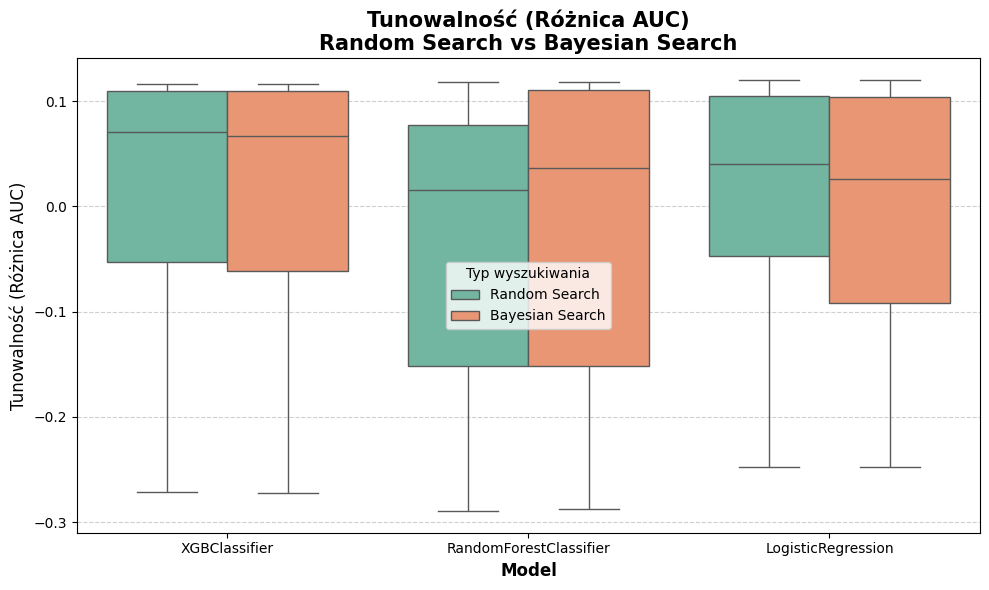

In [13]:
data_full['SearchType'] = 'Random Search'
data_full_bayes['SearchType'] = 'Bayesian Search'
data_plot = pd.concat([data_full, data_full_bayes], ignore_index=True)


plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Model", y="diff_score", 
    hue="SearchType", 
    data=data_plot, 
    palette='Set2'
)

plt.title("Tunowalność (Różnica AUC)\nRandom Search vs Bayesian Search", fontsize=15, fontweight='bold')
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("Tunowalność (Różnica AUC)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Typ wyszukiwania")
plt.tight_layout()
plt.show()


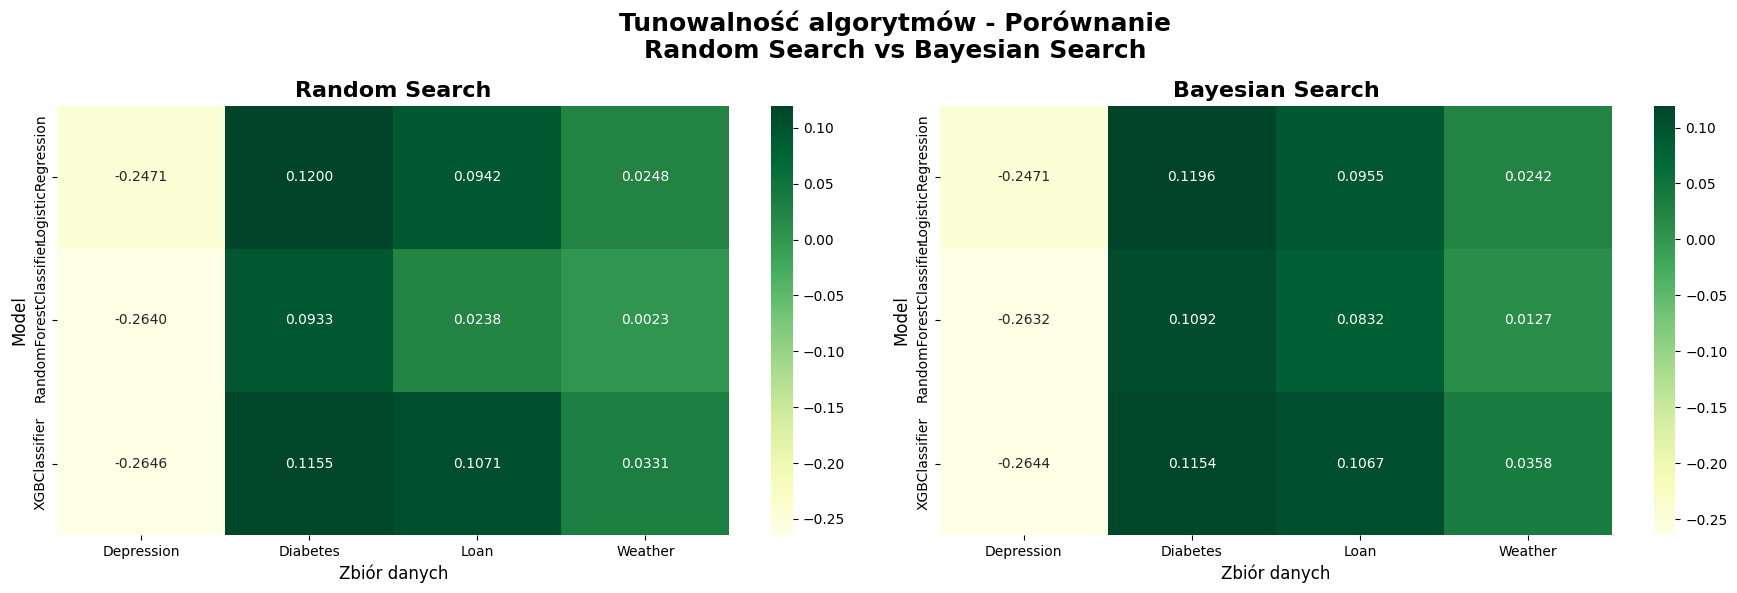

In [14]:
heatmap_data1 = data_plot[data_plot['SearchType'] == 'Random Search'].pivot_table(
    index="Model", 
    columns="Dataset", 
    values="diff_score", 
    aggfunc="mean"    
)

heatmap_data2 = data_plot[data_plot['SearchType'] == 'Bayesian Search'].pivot_table(
    index="Model", 
    columns="Dataset", 
    values="diff_score", 
    aggfunc="mean"   
)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(
    heatmap_data1, 
    annot=True, 
    fmt=".4f", 
    cmap="YlGn",
    ax=ax[0]    
)
ax[0].set_title("Random Search", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Zbiór danych", fontsize=12)
ax[0].set_ylabel("Model", fontsize=12)

sns.heatmap(
    heatmap_data2, 
    annot=True, 
    fmt=".4f",
    cmap="YlGn", 
    ax=ax[1]
)
ax[1].set_title("Bayesian Search", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Zbiór danych", fontsize=12)
ax[1].set_ylabel("Model", fontsize=12)

plt.suptitle("Tunowalność algorytmów - Porównanie\nRandom Search vs Bayesian Search", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


## (Ciekawostki) Analiza rozkładu klas w różnych grupach

In [ ]:
ft.plot_target_distribution_by_groups(data = pd.read_csv(list(dataset_targets.keys())[2]), target_col = dataset_targets[list(dataset_targets.keys())[2]])


Rozkład klas w grupach 'year':
 diabetes         0         1
year                        
2015      0.913346  0.086654
2016      0.912671  0.087329
2018      0.909261  0.090739
2019      0.915626  0.084374
2020      0.928571  0.071429
2021      0.857143  0.142857
2022      0.750000  0.250000
Chi2 dla 'year': 5.654181074415394, p-value: 0.4630210914691987
Brak istotnych różnic w rozkładzie klas między grupami w kolumnie 'year'.

Rozkład klas w grupach 'gender':
 diabetes         0         1
gender                      
0         0.923811  0.076189
1         0.902510  0.097490
Chi2 dla 'gender': 141.2490041603208, p-value: 1.4193639151521256e-32
Istnieje statystycznie istotna różnica w rozkładzie klas między grupami w kolumnie 'gender' (może występować sampling bias).

Rozkład klas w grupach 'race:AfricanAmerican':
 diabetes                     0         1
race:AfricanAmerican                    
0                     0.915598  0.084402
1                     0.912566  0.087434
Chi2 dla 

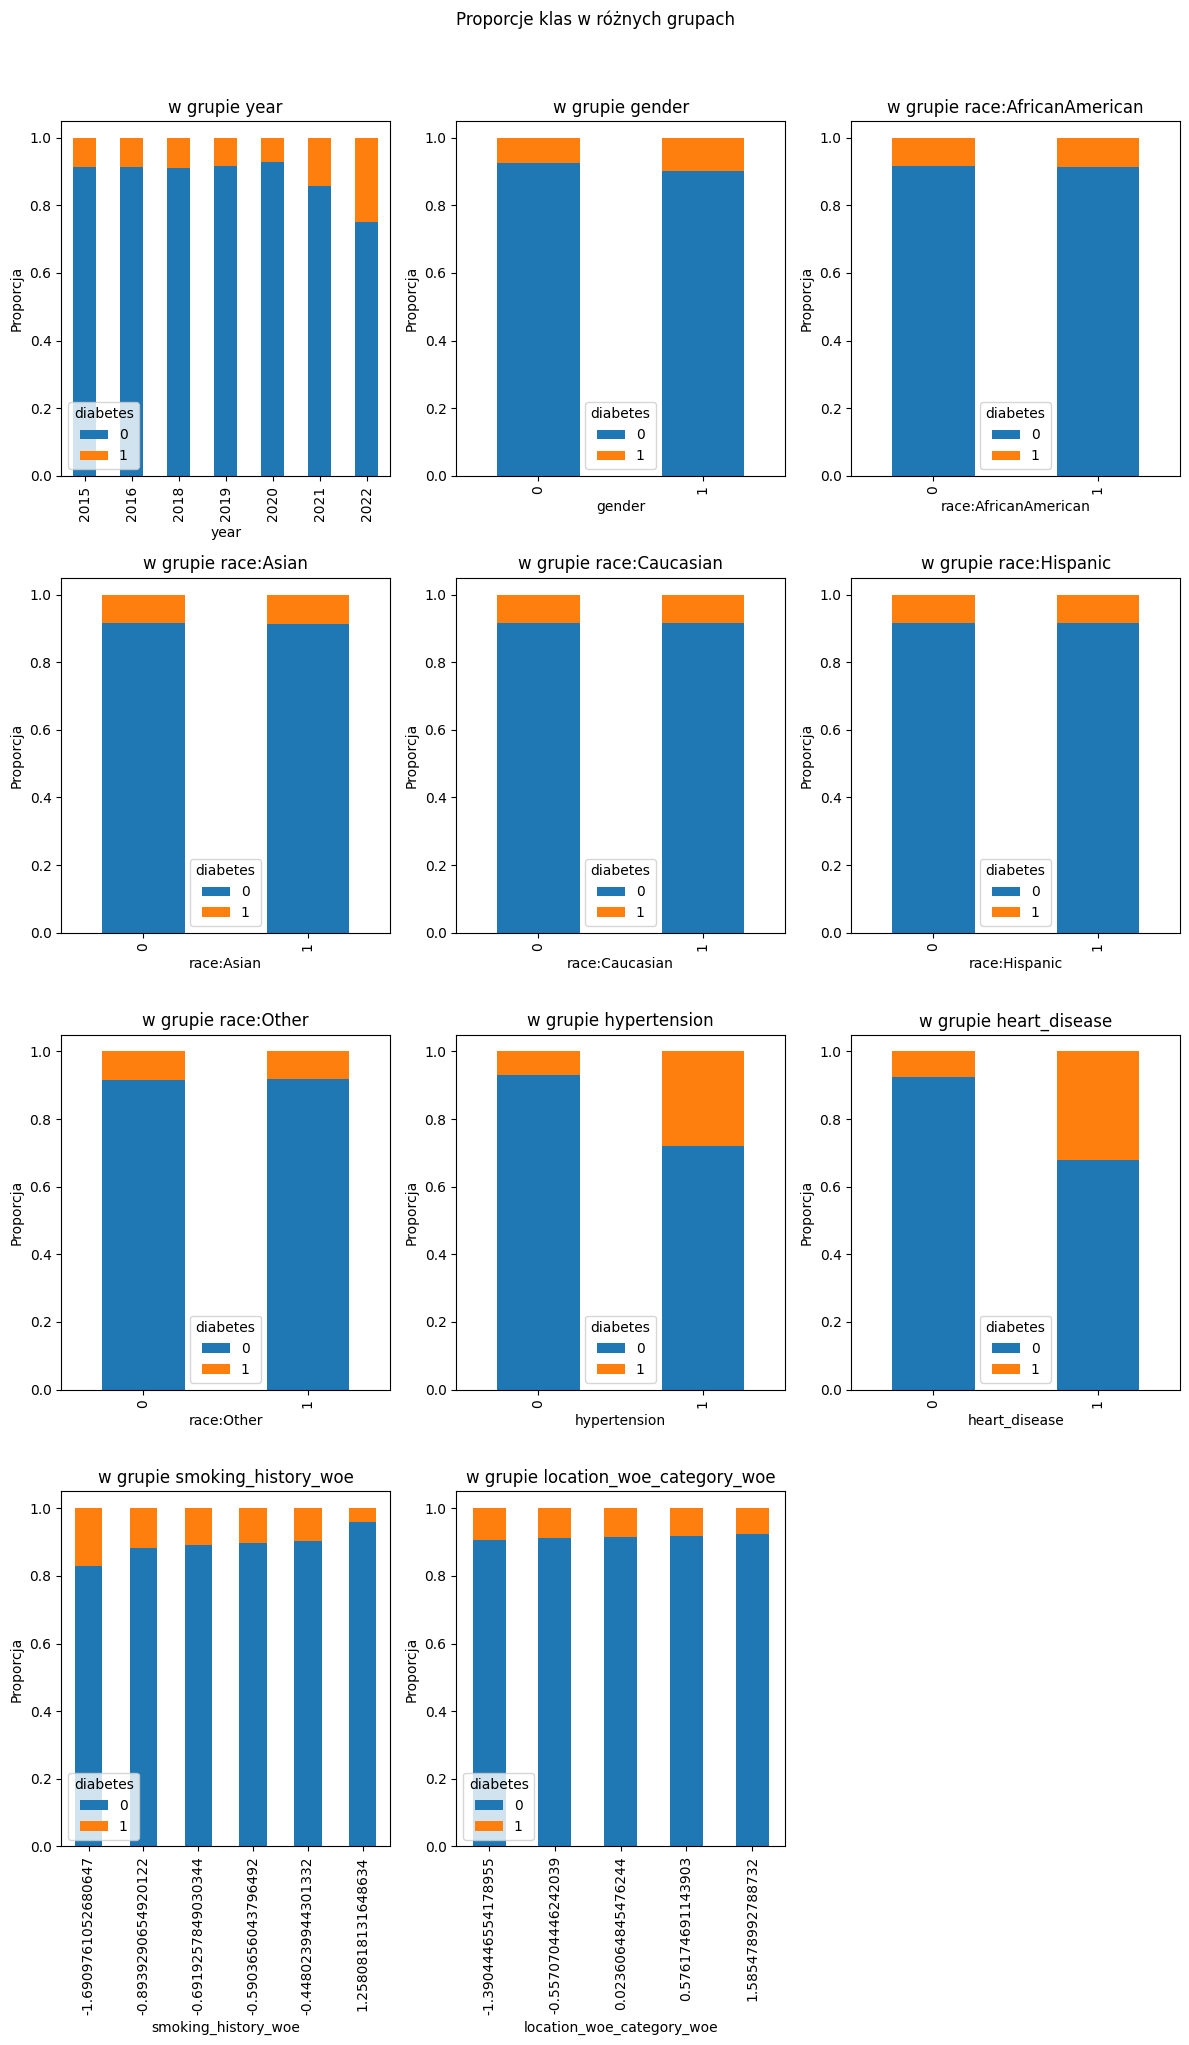

In [19]:
ft.plot_target_distribution_by_groups(data = pd.read_csv(list(dataset_targets.keys())[1]), target_col = dataset_targets[list(dataset_targets.keys())[1]])

im bardziej ujemna 'smoking_history_woe', wystąpienie nadciśnienia, chorób serca tym większe ryzyko wystąpienia cukrzycy

In [54]:
## TO DO: dodać takie same funckję dla innych ramek danych oraz zrobić analizę podziału danych i sprawdzić czy jets jakiś związek z odchylenimi wyników tunningu w losowych podziałach (dla cross validacji)

## (Ciekawostki) Analiza stabilności wyników tunningu (z podziałem na Random i Bayes Search)

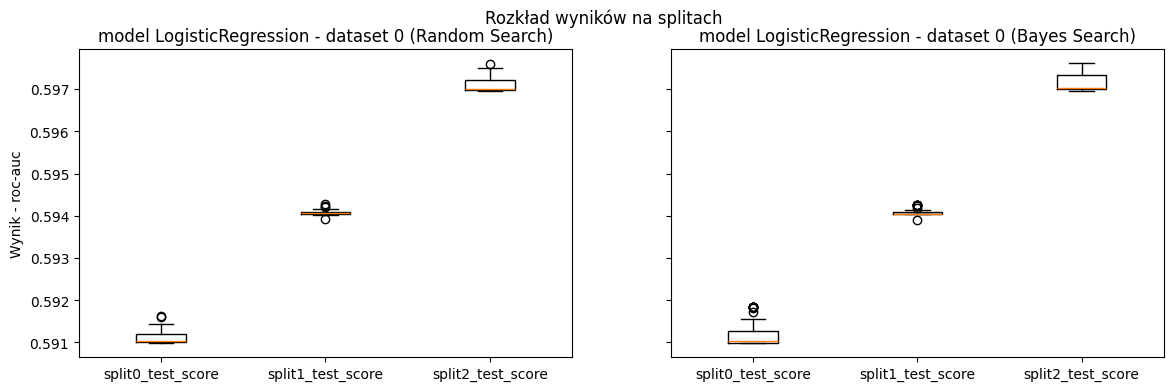

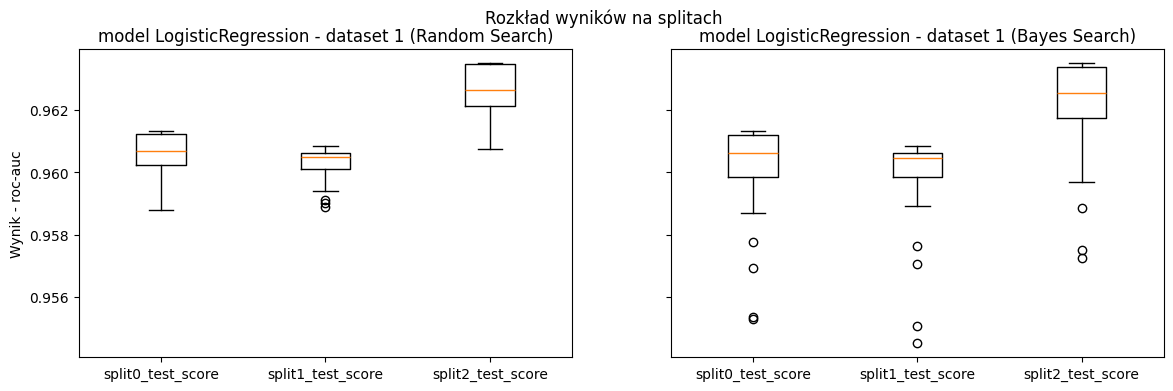

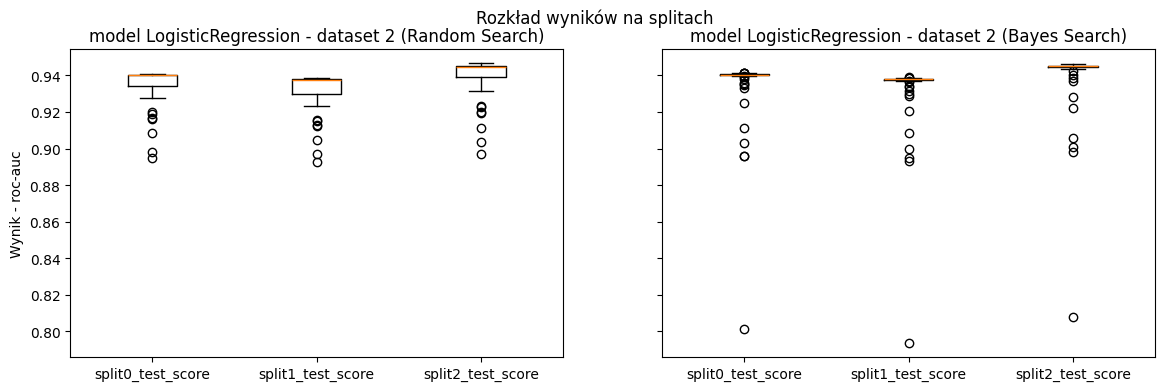

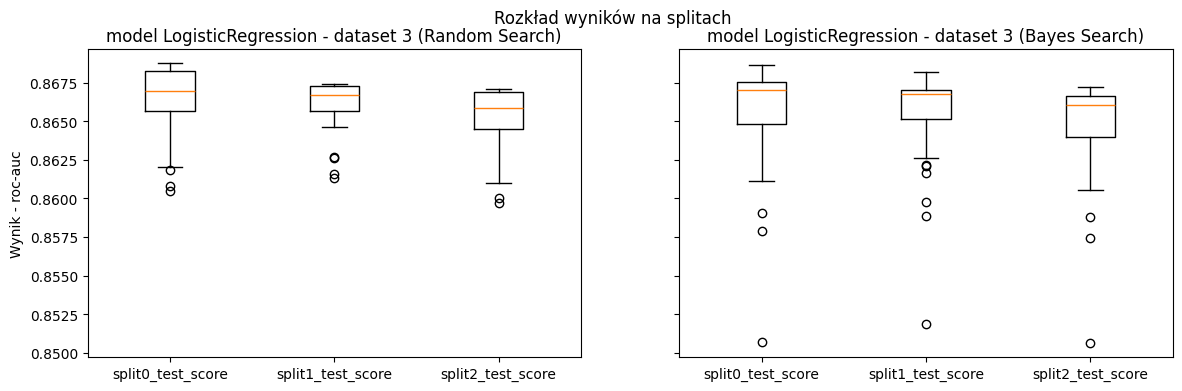

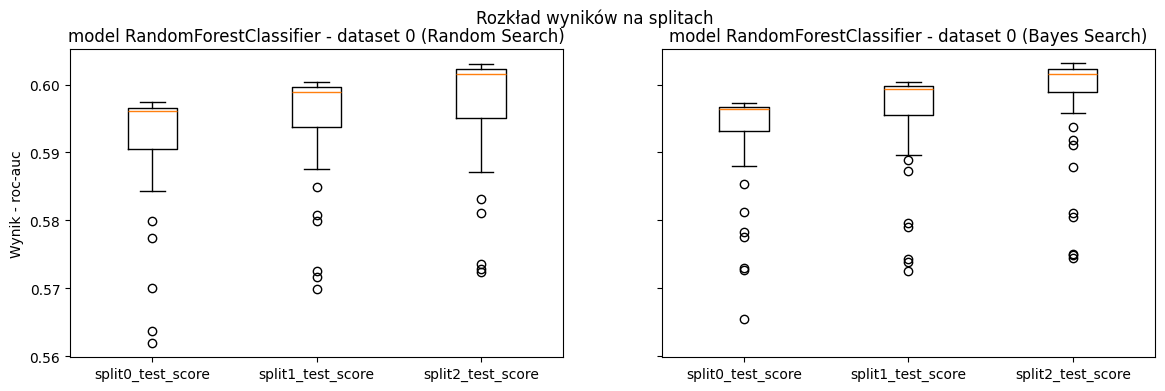

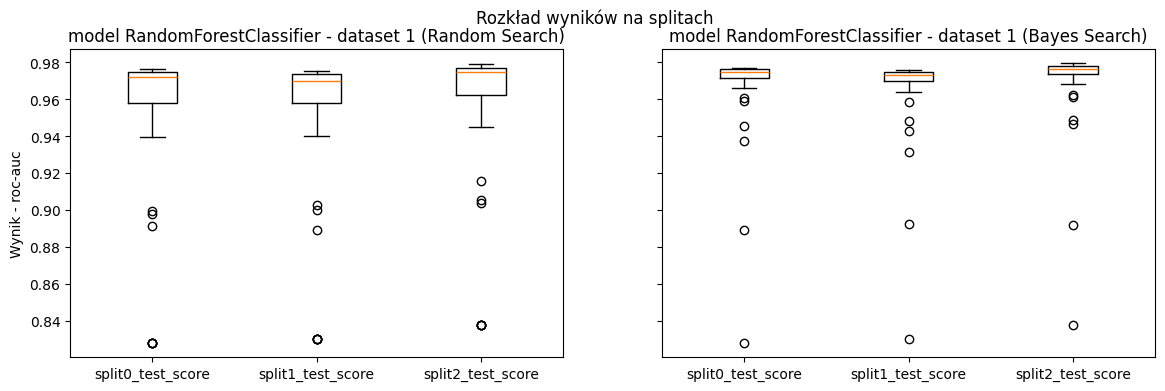

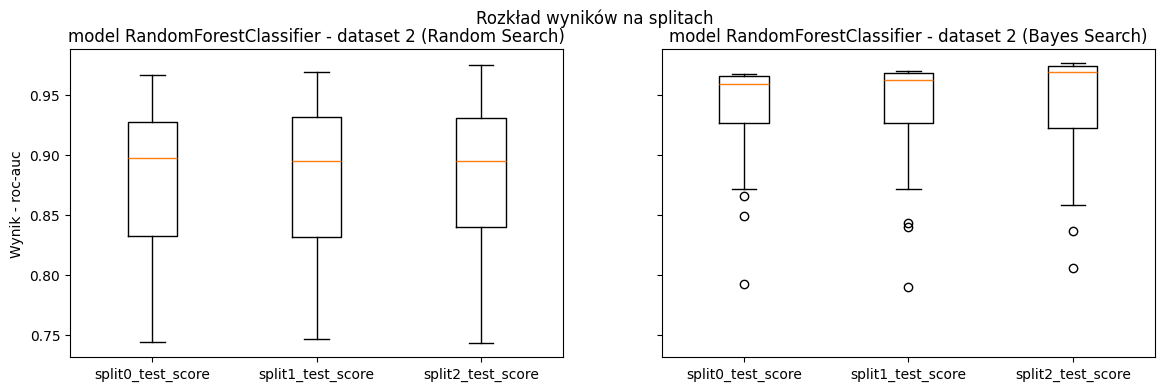

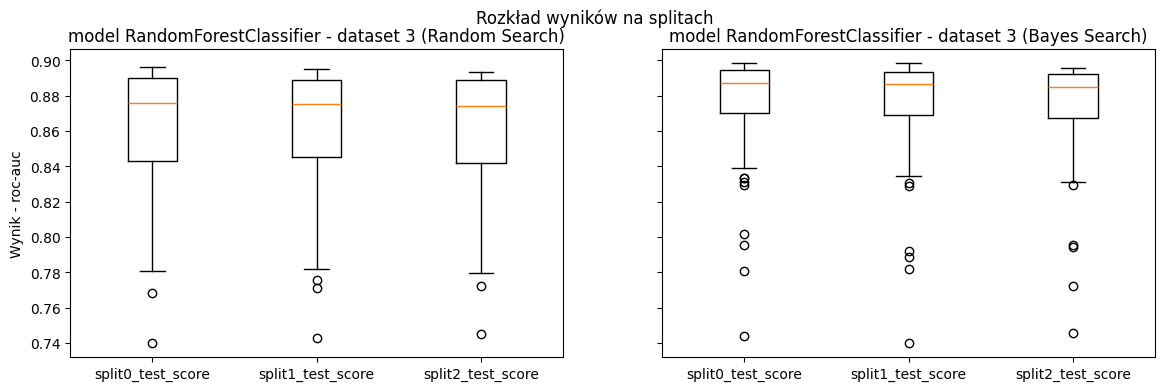

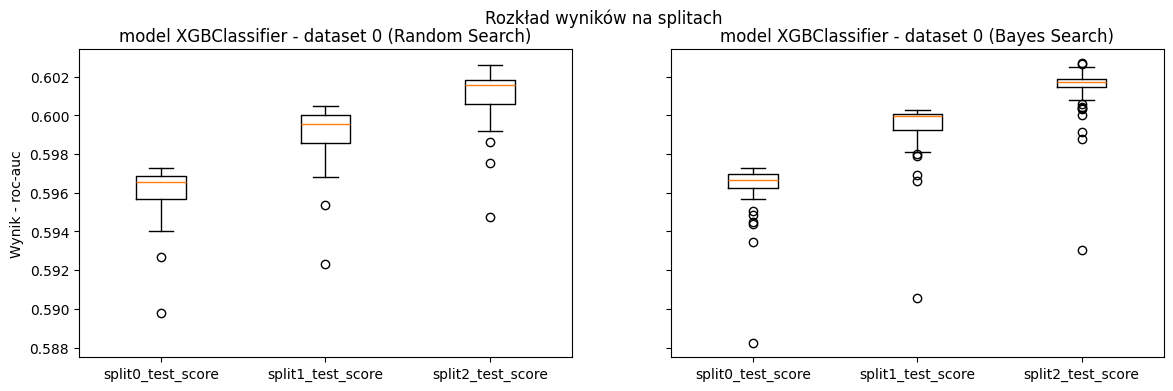

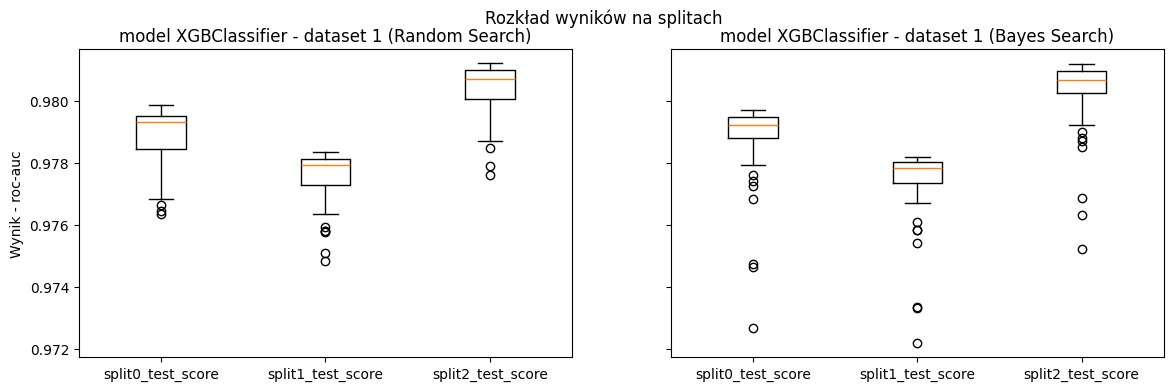

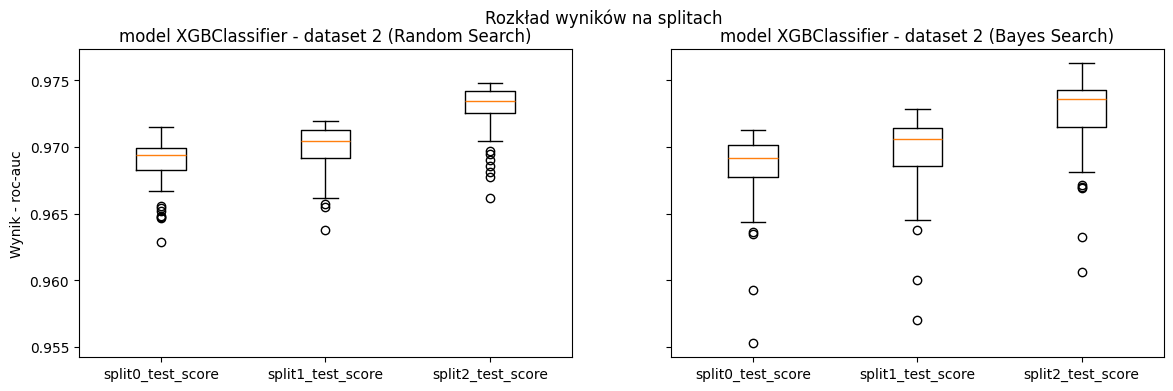

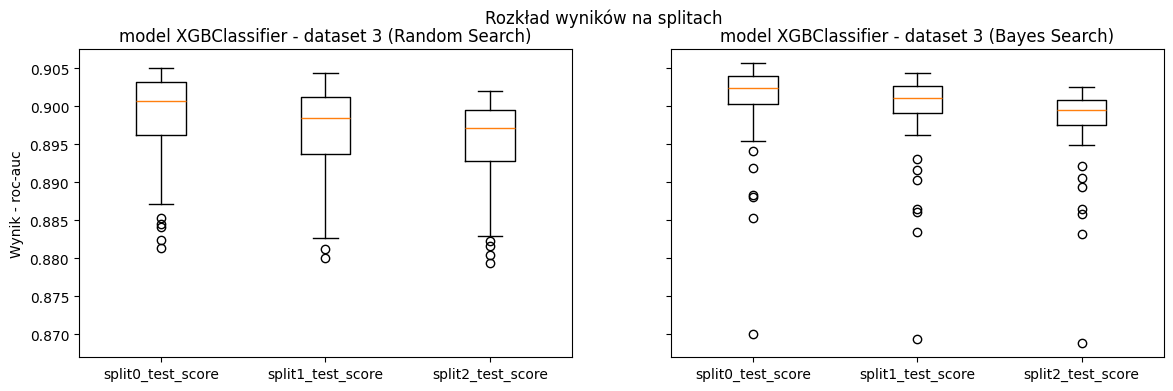

In [20]:
pattern = re.compile(r'random_search_results_(\w+)_dataset_(\d+)\.csv')

for filename in os.listdir('results_tunning'):
    results_rs = pd.read_csv(os.path.join('results_tunning', filename))
    if match := pattern.match(filename):
        model_name = match.group(1)
        dataset_num = match.group(2)
        results_bs = pd.read_csv(os.path.join('results_tunning', f'bayes_search_results_{model_name}_dataset_{dataset_num}.csv'))   
        splits = ['split0_test_score', 'split1_test_score', 'split2_test_score']
        fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
        
        ax[0].boxplot([results_rs[col] for col in splits], tick_labels=splits)
        ax[0].set_title(f'model {model_name} - dataset {dataset_num} (Random Search)')
        ax[0].set_ylabel('Wynik - roc-auc')
                
        ax[1].boxplot([results_bs[col] for col in splits], tick_labels=splits)
        ax[1].set_title(f'model {model_name} - dataset {dataset_num} (Bayes Search)')
        plt.suptitle('Rozkład wyników na splitach')
        plt.show()

In [ ]:
pattern = re.compile(r'random_search_results_(\w+)_dataset_(\d+)\.csv')
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score']

summary = []

for filename in os.listdir('results_tunning'):
    if match := pattern.match(filename):
        model_name = match.group(1)
        dataset_num = match.group(2)
        # Wczytaj wyniki Random Search
        results_rs = pd.read_csv(os.path.join('results_tunning', filename))
       
        results_bs = pd.read_csv(os.path.join('results_tunning', f'bayes_search_results_{model_name}_dataset_{dataset_num}.csv'))

        for method, results in [('Random', results_rs), ('Bayes', results_bs)]:
            means = [results[split].mean() for split in splits]
            stds = [results[split].std() for split in splits]
            row = {
                'model': model_name,
                'dataset': dataset_num,
                'method': method
            }
            for i, split in enumerate(splits):
                row[f'{split}_mean'] = means[i]
                row[f'{split}_std'] = stds[i]
            summary.append(row)

summary_df = pd.DataFrame(summary)

summary_df['mean_std'] = summary_df[[f'{split}_std' for split in splits]].mean(axis=1)

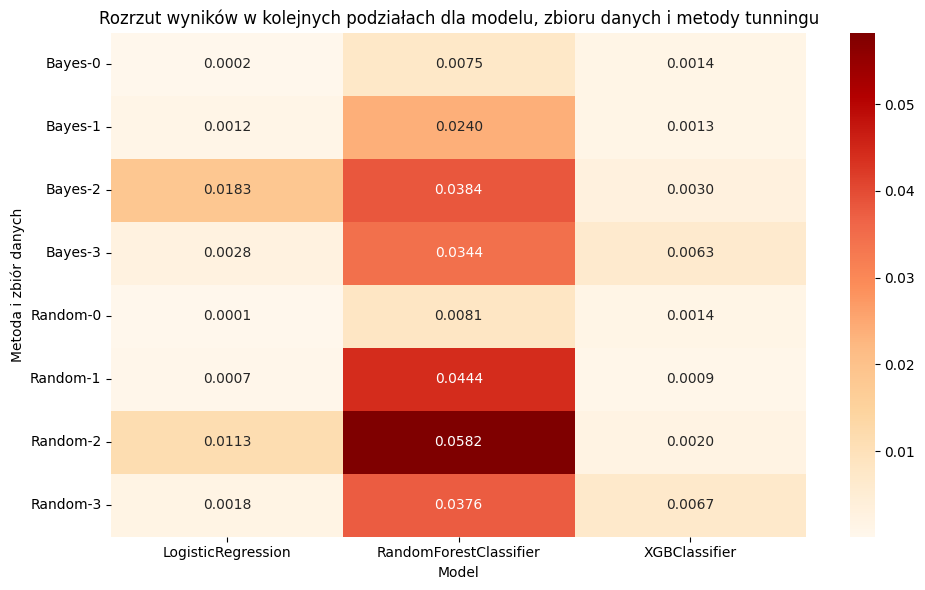

In [39]:
summary_pivot = summary_df.pivot_table(
    index=['method', 'dataset'], columns='model', values='mean_std'
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary_pivot, annot=True, fmt=".4f", cmap="OrRd")
plt.title('Rozrzut wyników w kolejnych podziałach dla modelu, zbioru danych i metody tunningu')
plt.ylabel('Metoda i zbiór danych')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

In [42]:
## TO DO: większa analiza i opis

Model Random forest wydaje się być najmniej stabilnym modelem ze względu na podział danych ( w szczególności zbiór danych 2 ("Loan")). Pozostałe dwa modele wydają się być stabilne. Różnice pomiędzy metodą tunningu są ale nie są bardzo znaczące (bayes i Random Search podobne wyniki). Zbiór 0 ('Depression') ma niskie odchylenia w roc-auc w kolejnych podziałach.

## Ewaluacja na zbiorze testowym z najlepszymi parametrami

Parametry z Random Search

In [ ]:
test_auc = {}
reports = {}
for model in itertools.product(range(len(models_names))):
    print(model[0])
    list_best_params = []
    list_best_params.extend(
        best_params[models_names[model[0]], j] for j in range(len(datasets))
    )
    auc, report = ft.test(models[model[0]], [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3], [X_test0, X_test1, X_test2, X_test3], [y_test0, y_test1, y_test2, y_test3], ft.to_dict(list_best_params[model[0]][0][1:-1].split(', ')))
    test_auc[model] = auc   
    reports[model] = report
    

0
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7465875138331439, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=2.232511569169687, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.052594450770640004,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1182, n_jobs=None,
              num_parallel_tree=None, ...)
Dataset 0: Test AUC: 0.5997303271137349
              precision    recall  f1-score   support

           0       0.81      0.16      0.26     57471
           1       0.32      0.91    

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Dataset 0: Test AUC: 0.5936836189879966
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     57471
           1       0.30      0.00      0.00     25283

    accuracy                           0.69     82754
   macro avg       0.50      0.50      0.41     82754
weighted avg       0.57      0.69      0.57     82754

LogisticRegression(C=0.030287008332244233, l1_ratio=0.6766738455558096,
                   max_iter=2636, penalty='l1', random_state=42, solver='saga')


c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio param

Dataset 1: Test AUC: 0.9634928450517309
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18254
           1       0.90      0.62      0.73      1743

    accuracy                           0.96     19997
   macro avg       0.93      0.81      0.86     19997
weighted avg       0.96      0.96      0.96     19997

LogisticRegression(C=0.030287008332244233, l1_ratio=0.6766738455558096,
                   max_iter=2636, penalty='l1', random_state=42, solver='saga')
Dataset 2: Test AUC: 0.9465438626632726
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6652
           1       0.95      0.67      0.78      1064

    accuracy                           0.95      7716
   macro avg       0.95      0.83      0.88      7716
weighted avg       0.95      0.95      0.95      7716

LogisticRegression(C=0.030287008332244233, l1_ratio=0.6766738455558096,
                   max_iter=2636, penalty=

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Dataset 3: Test AUC: 0.86286091632401
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21897
           1       0.72      0.48      0.57      6261

    accuracy                           0.84     28158
   macro avg       0.79      0.71      0.74     28158
weighted avg       0.83      0.84      0.83     28158



c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
res =[]
res.extend(
    {
        'Model': models_names[model[0]],
        'Data' : data
    }
    for model, (data) in test_auc.items()
)
results_df = pd.DataFrame(res)

results_df['dataset0'] = results_df['Data'].apply(lambda x: x[0])
results_df['dataset1'] = results_df['Data'].apply(lambda x: x[1])
results_df['dataset2'] = results_df['Data'].apply(lambda x: x[2])
results_df['dataset3'] = results_df['Data'].apply(lambda x: x[3])
results_df = results_df.drop(columns=['Data'])

results_long = results_df.melt(id_vars=['Model'], 
                               value_vars=['dataset0', 'dataset1', 'dataset2', 'dataset3'],
                               var_name='Dataset', 
                               value_name='Test ROC-AUC')

results_long['Dataset']= results_long['Dataset'].map({
    'dataset0': datasets[0],
    'dataset1': datasets[1],
    'dataset2': datasets[2],
    'dataset3': datasets[3]
})

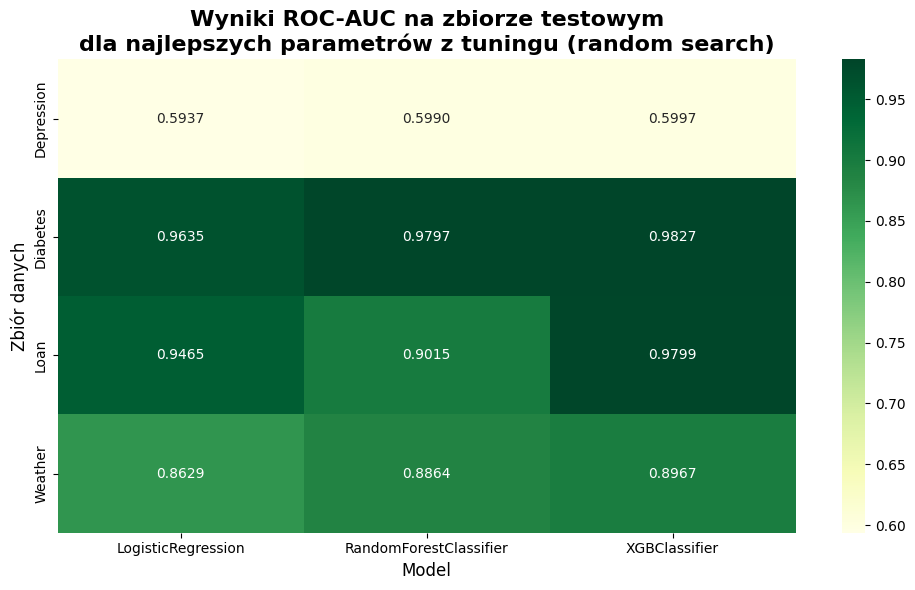

In [196]:
auc_pivot = results_long.pivot(index='Dataset', columns='Model', values='Test ROC-AUC')

plt.figure(figsize=(10, 6))
sns.heatmap(auc_pivot, annot=True, fmt=".4f", cmap="YlGn")
plt.title('Wyniki ROC-AUC na zbiorze testowym\ndla najlepszych parametrów z tuningu (random search)', fontsize=16, fontweight='bold')
plt.ylabel('Zbiór danych',fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.tight_layout()
plt.show()


In [39]:
test_auc_default = {}
reports_default = {}
for model in itertools.product(range(len(models_names))):
    list_default_params = default_params[models_names[model[0]]][0]
    auc, report = ft.test(models[model[0]], [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3], [X_test0, X_test1, X_test2, X_test3], [y_test0, y_test1, y_test2, y_test3], ft.to_dict(list_default_params[1:-1].split(', ')))
    test_auc_default[model] = auc   
    reports_default[model] = report
    

Dataset 0: Test AUC: 0.5996523209644544
              precision    recall  f1-score   support

           0       0.80      0.26      0.40     57471
           1       0.34      0.85      0.48     25283

    accuracy                           0.44     82754
   macro avg       0.57      0.56      0.44     82754
weighted avg       0.66      0.44      0.42     82754

Dataset 1: Test AUC: 0.9823708740328434
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     18254
           1       0.73      0.83      0.77      1743

    accuracy                           0.96     19997
   macro avg       0.86      0.90      0.87     19997
weighted avg       0.96      0.96      0.96     19997

Dataset 2: Test AUC: 0.9808153124844583
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6652
           1       0.91      0.87      0.89      1064

    accuracy                           0.97      7716
   macro

c:\Users\alapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
res_def =[]
res_def.extend(
    {
        'Model': models_names[model[0]],
        'Data' : data
    }
    for model, (data) in test_auc_default.items()
)
results_df_def = pd.DataFrame(res_def)

results_df_def['dataset0'] = results_df_def['Data'].apply(lambda x: x[0])
results_df_def['dataset1'] = results_df_def['Data'].apply(lambda x: x[1])
results_df_def['dataset2'] = results_df_def['Data'].apply(lambda x: x[2])
results_df_def['dataset3'] = results_df_def['Data'].apply(lambda x: x[3])
results_df_def = results_df_def.drop(columns=['Data'])

results_long_def = results_df_def.melt(id_vars=['Model'], 
                               value_vars=['dataset0', 'dataset1', 'dataset2', 'dataset3'],
                               var_name='Dataset', 
                               value_name='Test ROC-AUC')

results_long_def['Dataset']= results_long_def['Dataset'].map({
    'dataset0': datasets[0],
    'dataset1': datasets[1],
    'dataset2': datasets[2],
    'dataset3': datasets[3]
})

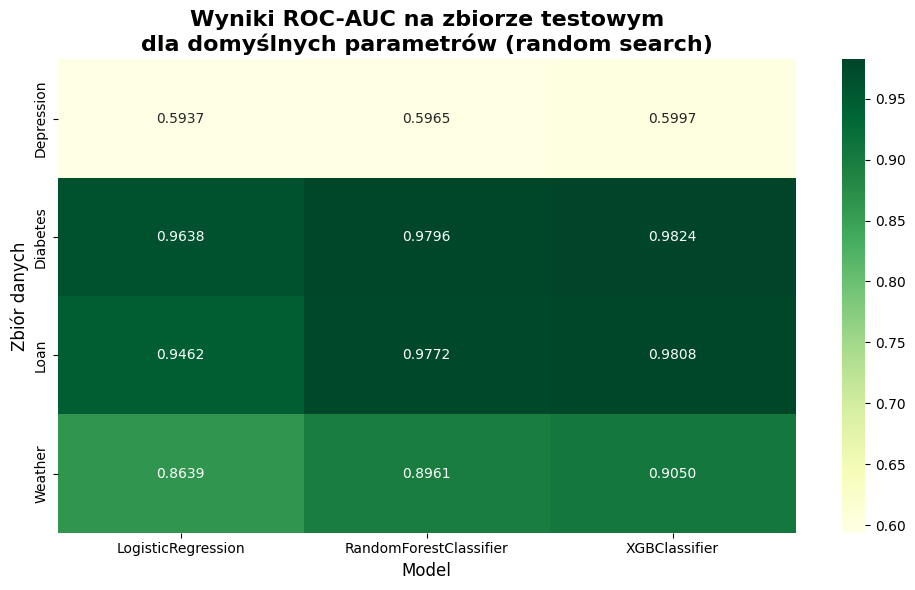

In [41]:
auc_pivot_def = results_long_def.pivot(index='Dataset', columns='Model', values='Test ROC-AUC')

plt.figure(figsize=(10, 6))
sns.heatmap(auc_pivot_def, annot=True, fmt=".4f", cmap="YlGn")
plt.title('Wyniki ROC-AUC na zbiorze testowym\ndla domyślnych parametrów (random search)', fontsize=16, fontweight='bold')
plt.ylabel('Zbiór danych',fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.tight_layout()
plt.show()
